In [64]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import time
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [ ]:
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

In [ ]:
sound_file_paths = ["57320-0-0-7.wav","24074-1-0-3.wav","15564-2-0-1.wav","31323-3-0-1.wav","46669-4-0-35.wav",
                   "89948-5-0-0.wav","40722-8-0-4.wav","103074-7-3-2.wav","106905-8-0-0.wav","108041-9-0-4.wav"]
sound_names = ["air conditioner","car horn","children playing","dog bark","drilling","engine idling",
               "gun shot","jackhammer","siren","street music"]

raw_sounds = load_sound_files(sound_file_paths)

In [ ]:
plot_waves(sound_names,raw_sounds)
plot_specgram(sound_names,raw_sounds)
plot_log_power_specgram(sound_names,raw_sounds)

In [2]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    features, labels = np.empty((0,193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, fn.split('/')[2].split('-')[1])
    return np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [3]:
x = extract_feature("audio/fold1/7061-6-0-0.wav")
nfMfccs = np.shape(x[0])[0]
nfChr = np.shape(x[1])[0]
nfMel = np.shape(x[2])[0]
nfCon = np.shape(x[3])[0]
nfTon = np.shape(x[4])[0]

/home/kyle/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array(a, dtype, copy=False, order=order)


In [4]:
parent_dir = 'audio'

sub_dirs = ['fold1','fold2','fold3']
features, labels = parse_audio_files(parent_dir,sub_dirs)

/home/kyle/anaconda2/lib/python2.7/site-packages/librosa/core/pitch.py:148: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/kyle/anaconda2/lib/python2.7/site-packages/librosa/util/utils.py:1478: RuntimeWarning: invalid value encountered in divide
  mask /= mask + (X_ref / Z)**power


In [10]:
labels = one_hot_encode(labels)

train_test_split = np.random.rand(len(features)) < 0.70
train_x = features[train_test_split]
train_y = labels[train_test_split]
test_x = features[~train_test_split]
test_y = labels[~train_test_split]

In [68]:
print "Number of features"
print "* Mfcc: {0}".format(nfMfccs)
print "* chroma-stft: {0}".format(nfChr)
print "* melspectrogram: {0}".format(nfMel)
print "* spectral_contrast: {0}".format(nfCon)
print "* tonnetz: {0}".format(nfTon)

Number of features
* Mfcc: 40
* chroma-stft: 12
* melspectrogram: 128
* spectral_contrast: 7
* tonnetz: 6


--------------------------------------------------------------------------------------------------------------------------

### Training Neural Network with TensorFlow

In [5]:
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support

In [6]:
training_epochs = 5000
n_dim = features.shape[1]
n_classes = 10
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [7]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [8]:
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
print ("---Training time: %s seconds ---" % (time.time() - start_time))

---Training time: 151.111130953 seconds ---


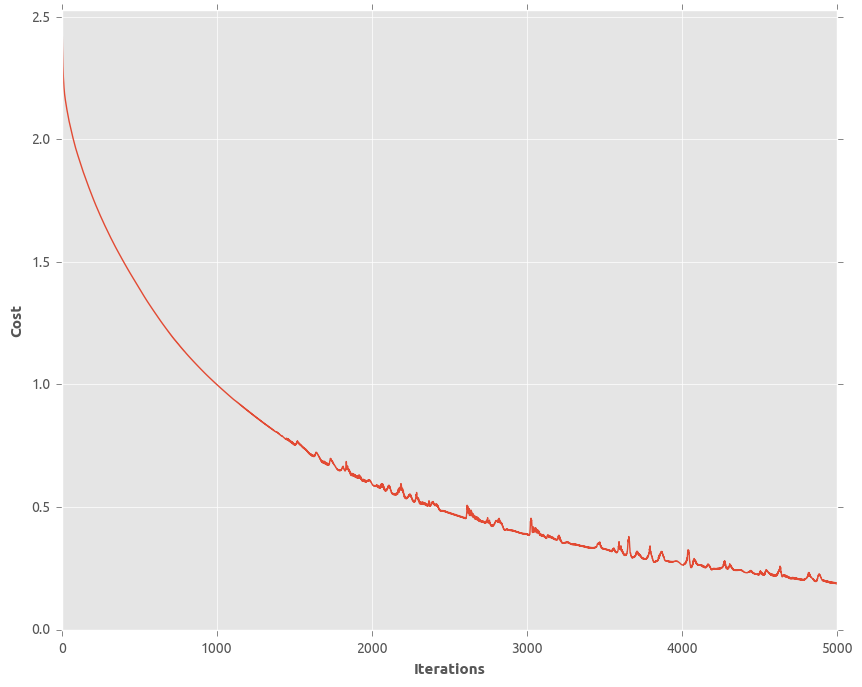

F-Score: 0.873


In [12]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print "F-Score:", round(f,3)

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
confusion_matrix(y_true, y_pred)

array([[ 84,   0,   0,   0,   0,   0,   0,   2,   0,   0],
       [  1,  32,   2,   1,   0,   4,   0,   0,   0,   2],
       [  1,   0,  82,   2,   3,   0,   0,   0,   1,   4],
       [  0,   0,   4,  74,   1,   2,   1,   0,   4,   2],
       [  0,   0,   2,   1,  88,   1,   1,   2,   1,   2],
       [  0,   1,   2,   3,   0,  86,   0,   0,   0,   1],
       [  1,   0,   0,   6,   0,   0,  26,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0, 111,   0,   0],
       [  1,   0,   3,   1,   0,   0,   0,   0,  78,   0],
       [  1,   0,  26,   5,   0,   2,   1,   0,   2,  55]])

In [ ]:
np.save("nn_features_fold_123", features, allow_pickle=True)

In [ ]:
np.save("nn_labels_fold_123", labels, allow_pickle=True)

### MFCCS standalone

In [15]:
train_x = features[train_test_split,:nfMfccs]
train_y = labels[train_test_split]
test_x = features[~train_test_split,:nfMfccs]
test_y = labels[~train_test_split]

In [16]:
np.shape(train_x)

(1866, 40)

In [17]:
training_epochs = 5000
n_dim = nfMfccs
n_classes = 10
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [18]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [19]:
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [20]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
print ("---Training time: %s seconds ---" % (time.time() - start_time))

---Training time: 122.902077913 seconds ---


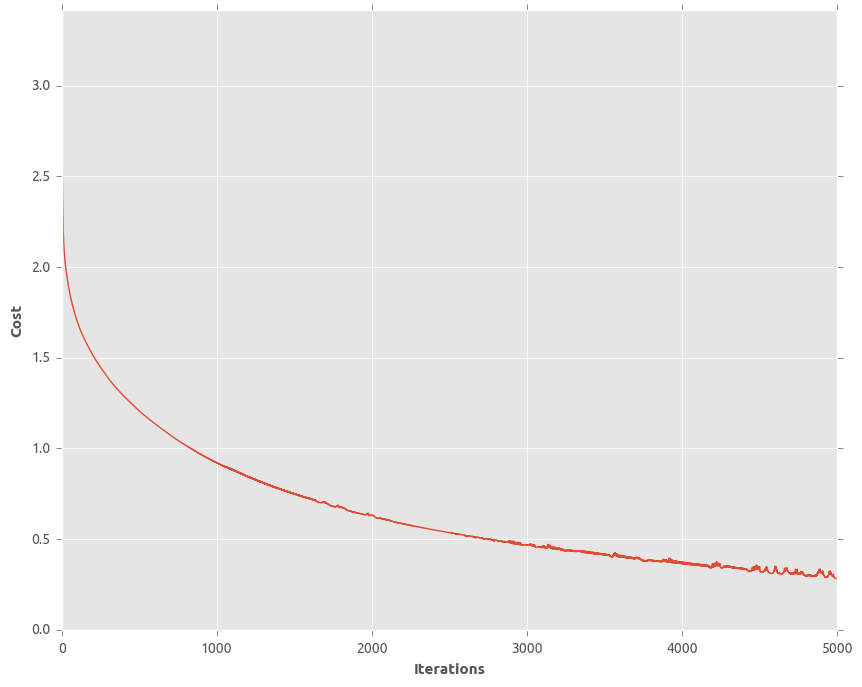

F-Score: 0.839


In [21]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print "F-Score:", round(f,3)

In [22]:
print "Confusion Matrix"
confusion_matrix(y_true, y_pred)

Confusion Matrix


array([[ 80,   0,   2,   0,   0,   0,   0,   1,   0,   3],
       [  0,  39,   0,   0,   0,   0,   0,   1,   0,   2],
       [  1,   0,  68,   6,   0,   3,   1,   0,   1,  13],
       [  1,   0,   7,  72,   2,   0,   3,   0,   2,   1],
       [  1,   0,   6,   2,  80,   0,   0,   3,   0,   6],
       [  0,   0,   2,   1,   0,  88,   0,   0,   0,   2],
       [  0,   0,   0,   6,   0,   1,  22,   1,   1,   2],
       [  2,   0,   0,   0,   1,   0,   0, 109,   0,   0],
       [  0,   0,   3,   1,   1,   0,   0,   0,  76,   2],
       [  3,   0,  19,   8,   1,   6,   0,   1,   0,  54]])

### chorma-stft standalone

In [32]:
train_x = features[train_test_split,nfMfccs:nfMfccs+nfChr]
train_y = labels[train_test_split]
test_x = features[~train_test_split,nfMfccs:nfMfccs+nfChr]
test_y = labels[~train_test_split]

In [33]:
np.shape(train_x)

(1866, 12)

In [34]:
training_epochs = 5000
n_dim = nfChr
n_classes = 10
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [35]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.initialize_all_variables()

cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [36]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
print ("---Training time: %s seconds ---" % (time.time() - start_time))

---Training time: 116.704131126 seconds ---


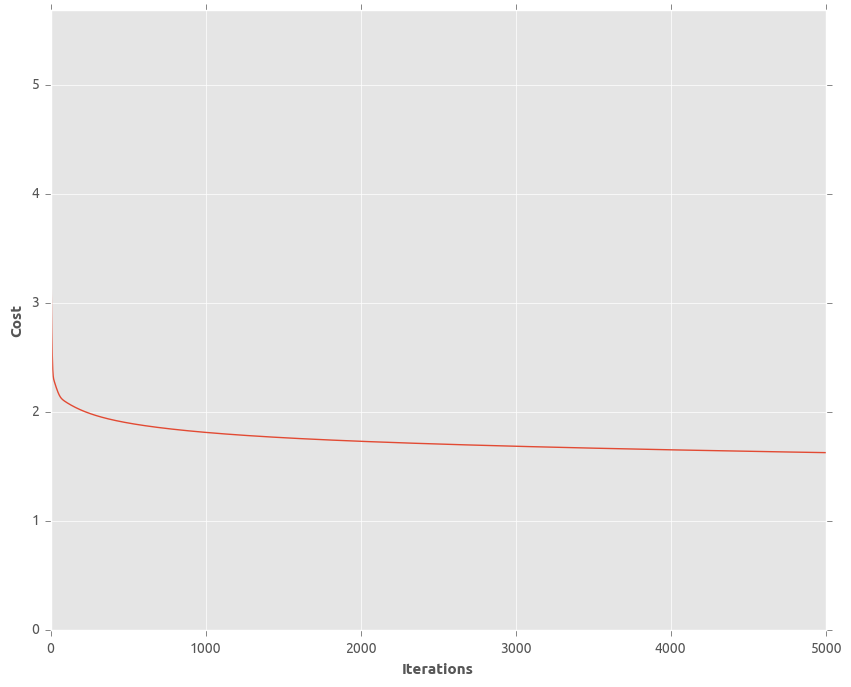

F-Score: 0.434


In [37]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print "F-Score:", round(f,3)

In [38]:
print "Confusion Matrix"
confusion_matrix(y_true, y_pred)

Confusion Matrix


array([[13,  0,  1,  1,  8, 14,  0, 42,  2,  5],
       [ 0, 31,  0,  1,  0,  2,  0,  0,  4,  4],
       [ 1,  0, 60, 10,  2,  3,  0,  6,  5,  6],
       [ 2,  3, 34, 21,  5,  3,  0,  4, 11,  5],
       [ 9,  1,  4,  7, 35,  7,  0, 30,  4,  1],
       [ 2,  0,  2,  6,  7, 43,  0, 30,  0,  3],
       [ 1,  0,  0,  0,  0,  1,  0, 31,  0,  0],
       [16,  0,  0,  0, 14, 17,  0, 65,  0,  0],
       [ 0,  0,  7,  8,  0,  4,  0,  4, 58,  2],
       [ 4,  3, 18, 13,  3,  6,  0,  6,  9, 30]])

### melspectrogram standalone

In [39]:
train_x = features[train_test_split,nfMfccs+nfChr:nfMfccs+nfChr+nfMel]
train_y = labels[train_test_split]
test_x = features[~train_test_split,nfMfccs+nfChr:nfMfccs+nfChr+nfMel]
test_y = labels[~train_test_split]

In [40]:
training_epochs = 5000
n_dim = nfMel
n_classes = 10
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [41]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.initialize_all_variables()

cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [42]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
print ("---Training time: %s seconds ---" % (time.time() - start_time))

---Training time: 139.324635983 seconds ---


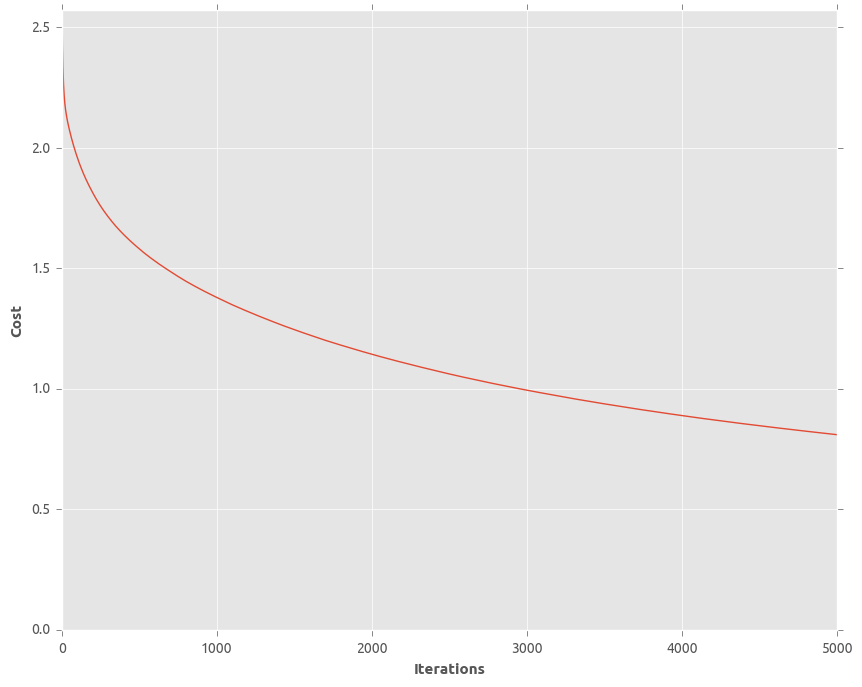

F-Score: 0.682


In [43]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print "F-Score:", round(f,3)

In [44]:
print "Confusion Matrix"
confusion_matrix(y_true, y_pred)

Confusion Matrix


array([[ 66,   0,  12,   0,   0,   2,   1,   0,   2,   3],
       [  1,  27,   2,   1,   5,   1,   0,   1,   0,   4],
       [  8,   1,  52,  14,   3,   0,   1,   2,   6,   6],
       [  1,   3,  14,  56,   0,   1,   1,   3,   6,   3],
       [  5,   0,  13,   6,  68,   1,   0,   3,   0,   2],
       [  8,   1,   1,   1,   0,  77,   0,   1,   3,   1],
       [  5,   0,   7,   3,   1,   1,  13,   2,   0,   1],
       [  3,   0,   1,   0,   3,   1,   0, 103,   0,   1],
       [  3,   0,  23,   3,   0,   0,   0,   0,  51,   3],
       [  3,   1,  29,   4,   3,   1,   1,   3,   1,  46]])

### spectral_contrast

In [52]:
train_x = features[train_test_split,nfMfccs+nfChr+nfMel:nfMfccs+nfChr+nfMel+nfCon]
train_y = labels[train_test_split]
test_x = features[~train_test_split,nfMfccs+nfChr+nfMel:nfMfccs+nfChr+nfMel+nfCon]
test_y = labels[~train_test_split]

In [53]:
training_epochs = 5000
n_dim = nfCon
n_classes = 10
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [54]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.initialize_all_variables()

cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [55]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
print ("---Training time: %s seconds ---" % (time.time() - start_time))

---Training time: 151.877357006 seconds ---


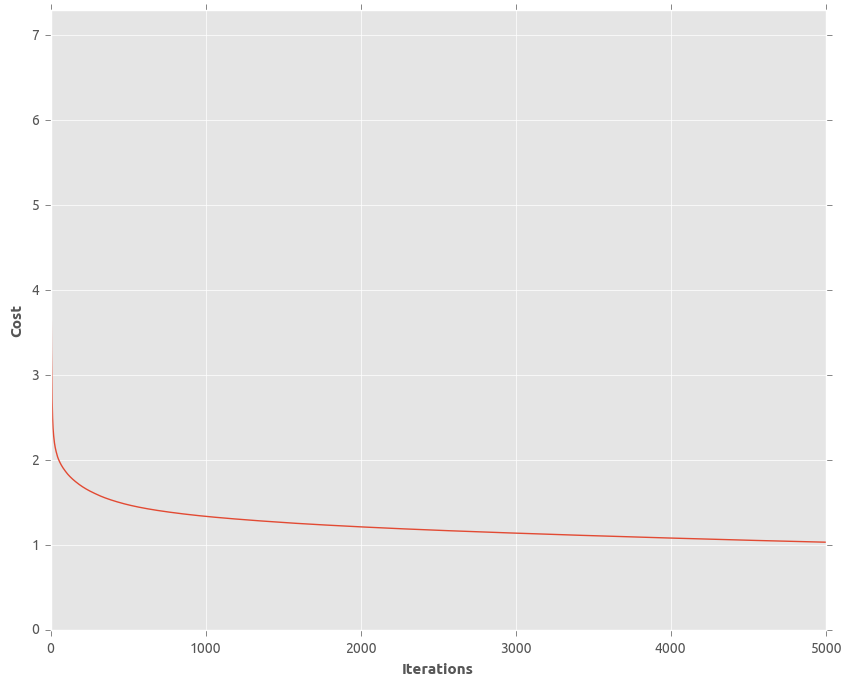

F-Score: 0.611


In [56]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print "F-Score:", round(f,3)

In [57]:
print "Confusion Matrix"
confusion_matrix(y_true, y_pred)

Confusion Matrix


array([[62,  0,  6,  3,  4,  3,  0,  7,  0,  1],
       [ 2, 31,  0,  3,  3,  0,  0,  0,  1,  2],
       [ 7,  0, 49,  6,  5,  1,  0,  2,  5, 18],
       [ 3,  5, 14, 50,  4,  2,  1,  2,  2,  5],
       [ 8,  3,  9,  8, 50,  2,  0,  9,  3,  6],
       [15,  0,  0,  1,  5, 50,  0, 17,  3,  2],
       [ 3,  0,  1,  0,  2,  2,  8, 14,  2,  1],
       [ 3,  0,  0,  1,  4,  7,  0, 96,  1,  0],
       [ 1,  2,  6,  6,  0,  1,  0,  2, 62,  3],
       [ 6,  2, 16, 13,  7,  2,  0,  2,  1, 43]])

### Tonnetz

In [58]:
train_x = features[train_test_split,nfMfccs+nfChr+nfMel+nfCon:nfMfccs+nfChr+nfMel+nfCon+nfTon]
train_y = labels[train_test_split]
test_x = features[~train_test_split,nfMfccs+nfChr+nfMel+nfCon:nfMfccs+nfChr+nfMel+nfCon+nfTon]
test_y = labels[~train_test_split]

In [59]:
training_epochs = 5000
n_dim = nfTon
n_classes = 10
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [60]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.initialize_all_variables()

cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [61]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))    
print ("---Training time: %s seconds ---" % (time.time() - start_time))

---Training time: 124.952039003 seconds ---


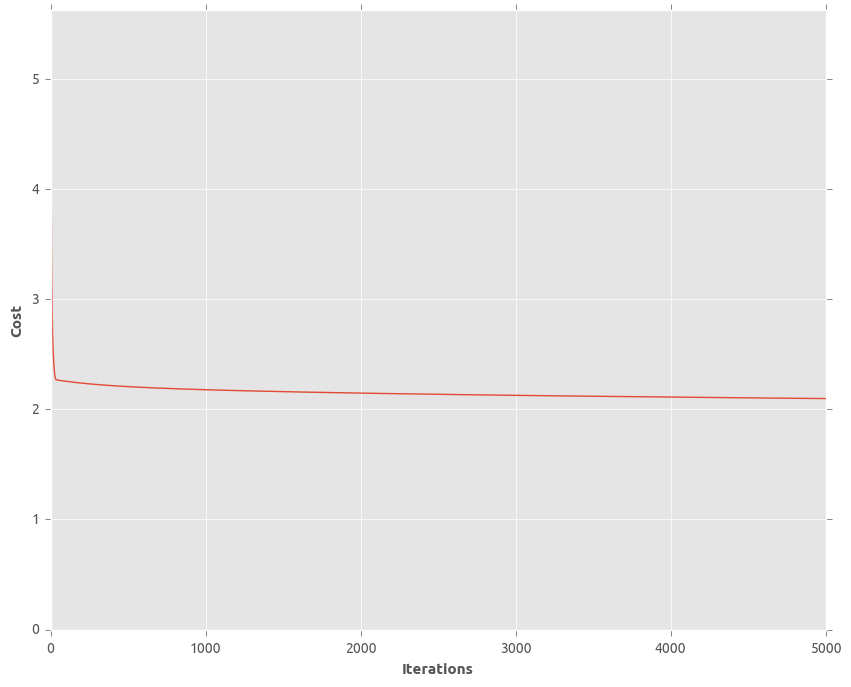

F-Score: 0.229


In [62]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print "F-Score:", round(f,3)

In [63]:
print "Confusion Matrix"
confusion_matrix(y_true, y_pred)

Confusion Matrix


array([[32,  0, 15,  8,  1,  4,  0, 18,  8,  0],
       [ 4, 11,  1,  4,  1,  6,  0, 11,  4,  0],
       [ 2,  0, 15, 10,  1,  1,  0, 41, 23,  0],
       [ 3,  0, 14, 15,  0,  4,  0, 44,  8,  0],
       [ 6,  1,  4,  6,  3, 13,  0, 49, 16,  0],
       [18,  6,  3,  3, 10, 20,  2, 23,  8,  0],
       [ 1,  0,  8,  7,  0,  0,  0, 16,  1,  0],
       [ 8,  4,  6,  7,  5,  7,  0, 65, 10,  0],
       [ 7,  0,  2,  4,  0,  7,  0, 36, 27,  0],
       [18,  0,  8, 12,  1,  5,  0, 30, 18,  0]])